**Part 2 ‑ Experiment and metrics design**

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

**Part 3 ‑ Predictive modeling**

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occ

In [2]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#load data and visualize
with open(r'ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000



It looks like the users will need to be labled by active or inactive and categorical variables must be encoded. The null values must be accounted for. There is no way to know the  reason for the missing ratings. I could fill with the mean value so as to not affect the current distribution, which is primarily high ratings.

In [6]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

The target variable will be whether the user was active in the sixth month from January. So was the user active in June?  

In [7]:
#set as datatime objects
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

In [8]:
#encode target variable 'active' as true or false for last trip in june
df['active'] = [1 if x.month >= 6 else 0 for x in df.last_trip_date]
#encode ultimate_black_user as categorical 
df['ultimate_black_user'] = [1 if x == True else 0 for x in df.ultimate_black_user]
df = df.drop(['last_trip_date', 'signup_date'], axis =1)

Percent of Active Users: 0.37608


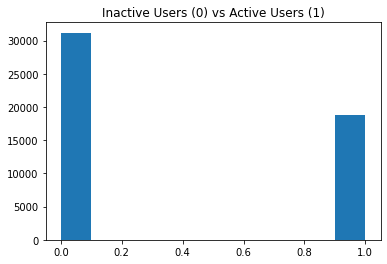

In [9]:
plt.hist(df.active)
plt.title('Inactive Users (0) vs Active Users (1)')
plt.show
print('Percent of Active Users: {}'.format(sum(df.active)/len(df.active))) #calculate ratio of active to inactive users

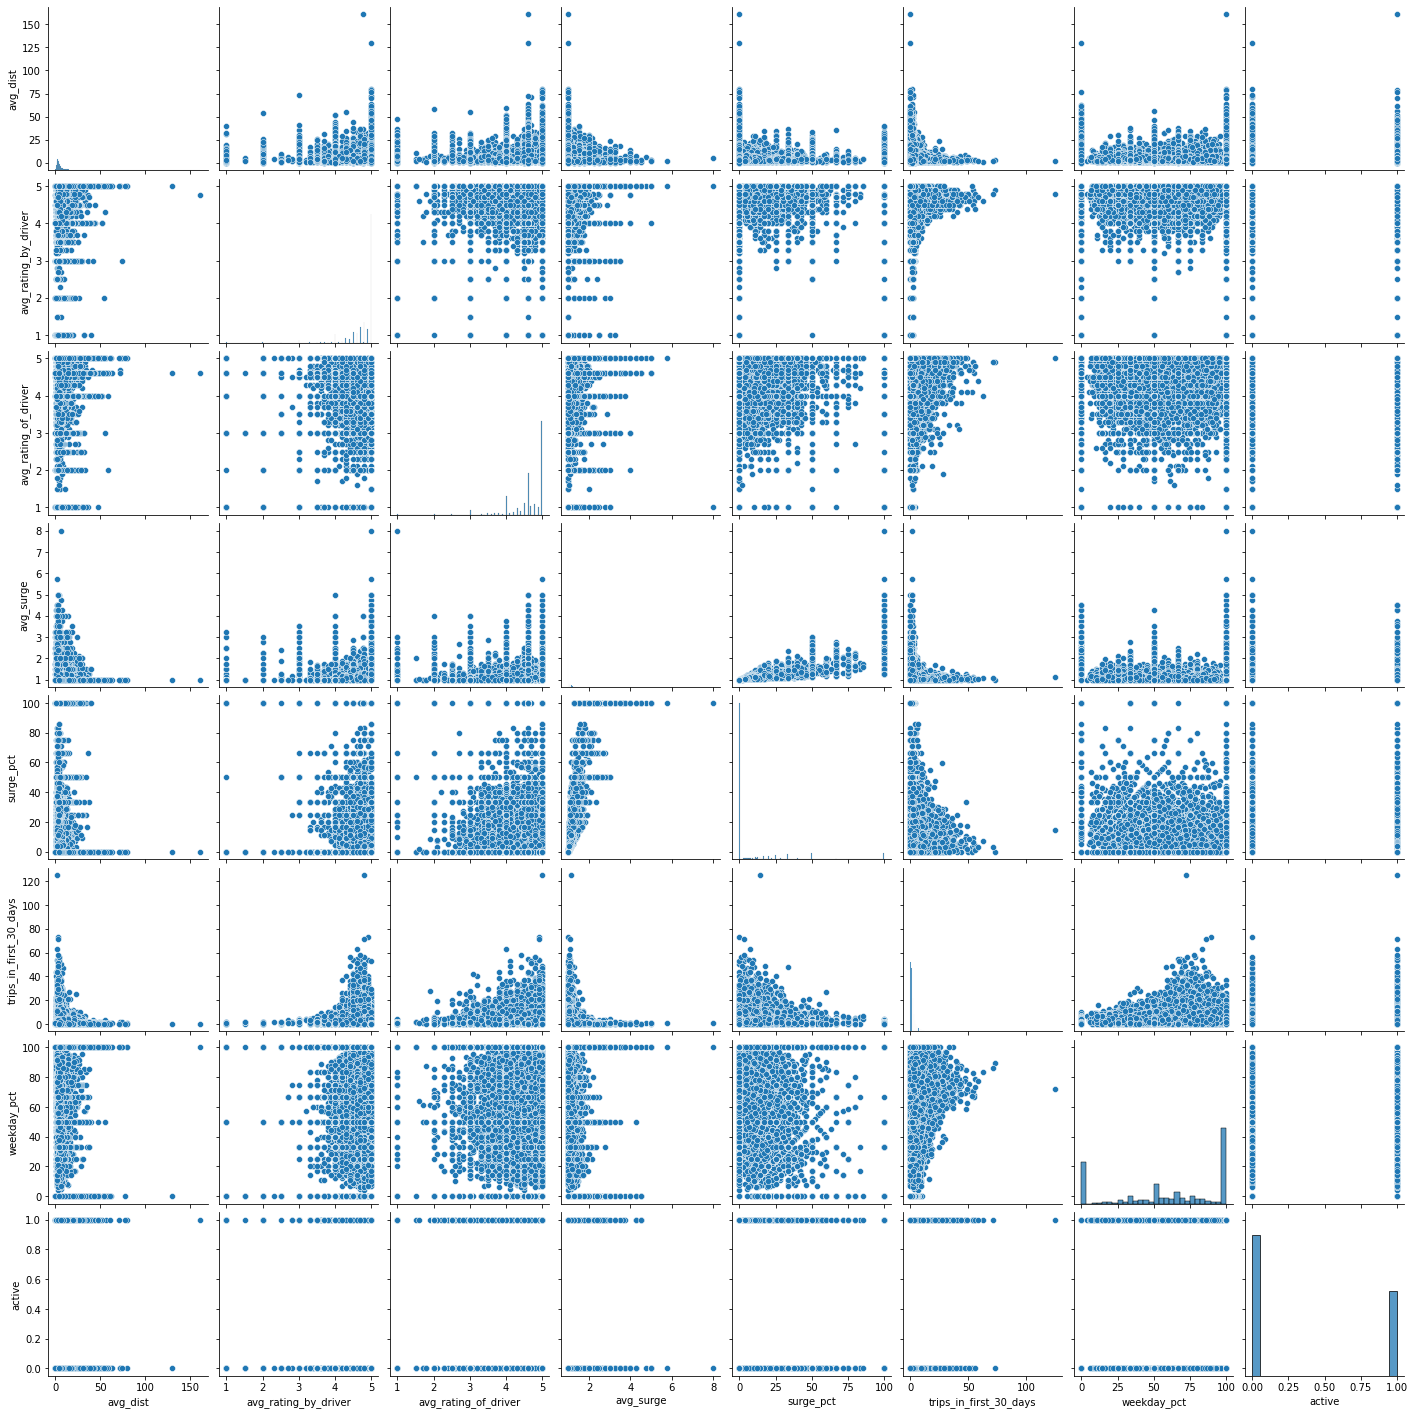

In [10]:
#select out only continuous variables
df_pp = df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
           'surge_pct', 'trips_in_first_30_days', 'weekday_pct', 'active']]
#plot
sns.pairplot(df_pp)

It looks like some variables correlate with each other, so that takes linear regression out.  Some other models to consider might be SVC, KNeighbors, RandomForrest.  SVC works well with higher dimensional data, while RandomForrest has problems with noisy data like this, so I plan to try KNeighbors.

In [11]:
#KNeighbors requires discrete variables be encoded
df = pd.get_dummies(df)
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#seperate data and labels
data = df.drop('active', axis=1)
labels = df.active

#split .33 to .67
X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

#normalize both sets post-split
X_train = normalize(X_train)
y_train = normalize(y_train)

In [13]:
from sklearn.neighbors import KNeighborsClassifier

#lets try the out of the box classifier with 10 neighbors
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, X_test)

#test the accuracy
knn.score(y_train, y_test)

0.7476363636363637

In [14]:
from sklearn.model_selection import GridSearchCV

#specify a parameter grid to search over
parameters = {
    'n_neighbors': [10, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn_cv = GridSearchCV(knn, parameters, cv=5) #specify GridSearchCV object

knn_cv.fit(X_train, X_test) #fit to training data

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=10, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [10, 13, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [15]:
#find classifiers best parameters
knn_cv.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}

In [16]:
#check for accuracy improvement
knn_cv.score(y_train, y_test)

0.7587878787878788

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

#predict classifications
y_pred = knn_cv.predict(y_train)

print(classification_report(y_test, y_pred)) # print classification report and confusion matrix

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81     10305
           1       0.71      0.61      0.66      6195

    accuracy                           0.76     16500
   macro avg       0.75      0.73      0.74     16500
weighted avg       0.75      0.76      0.75     16500

confusion matrix:
[[8720 1585]
 [2395 3800]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


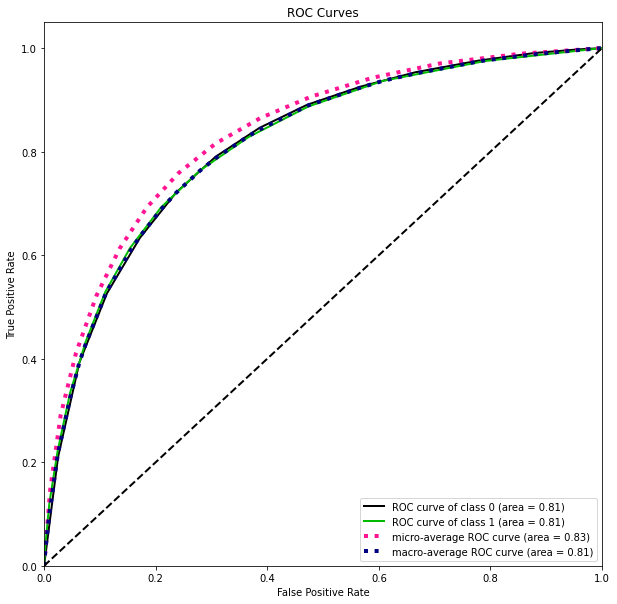

AUC score: 0.7297945354343844


In [20]:
!pip install scikit-plot
import scikitplot as skplt
from sklearn.metrics import roc_auc_score

#plot roc curve and  print AUV score
y_probas = knn_cv.predict_proba(y_train)
skplt.metrics.plot_roc_curve(y_test, y_probas, figsize=(10,10))
plt.show()
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))

In [21]:
#find feature importance

from sklearn.model_selection import cross_val_score

#instate a new classifier 

#to be used as index for feature number
n_feats = data.shape[1]

#loop over each feature, cross validate and print score
print('Feature  Accuracy')
for i in range(n_feats):
    X = data.iloc[:, i].values.reshape(-1, 1)
    knn_feat_test = KNeighborsClassifier(n_neighbors=13, weights='uniform', metric='manhattan')
    scores = cross_val_score(knn_feat_test, X, labels)
    print('%d        %g' % (i, scores.mean()))

Feature  Accuracy
0        0.63902
1        0.68226
2        0.70436
3        0.71518
4        0.62362
5        0.72672
6        0.59282
7        0.7067
8        0.57282
9        0.67584
10        0.53038
11        0.62392
12        0.59754


Using cross-validation you can see that the main features of this data set in terms of the target variable are features 3, 4, and 7 avg_surge, surge_pct, and weekday_pct.

Text(0.5, 1.0, 'weekday_pct for users active @ 6 months')

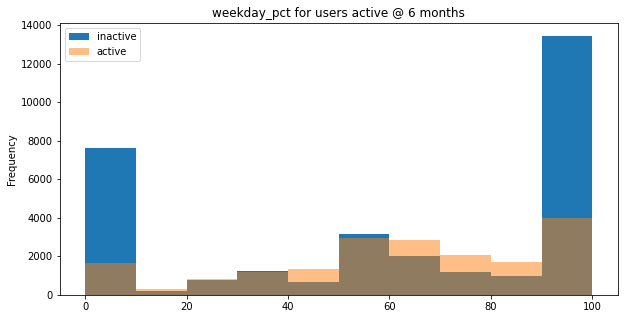

In [22]:
#subset active and inactive users for feature 7
feat_7_active = df.weekday_pct.loc[df['active'] == 1]
feat_7_inactive = df.weekday_pct.loc[df['active'] == 0]

plt.figure(figsize=(10,5))

#plot
feat_7_inactive.plot(kind='hist')
feat_7_active.plot(kind='hist', alpha=0.5)
plt.legend(['inactive', 'active'])
plt.title('weekday_pct for users active @ 6 months' )


For both classes there are users who ride exclusively during the weekdays or during the weekends. It seems a  mix of both was a better indicator for users who will be active at 6 months. It is more likely that being an exclusive weekender or exclusive weekdayer is a strong indicator of potential user loss. 